# Allocation and scheduling

This notebook demonstrates a model for solving a scheduling+allocation problem.

The setting is the following.
As set of `n_tasks` tasks has to be scheduled within a given horizon, and must be allocated to some team.
Not all teams can execute any task, and hence, we cannot simply use a `Cumulative` constraint.

Instead, we model the problem using optional tasks (= optional interval variables).
In particular, we duplicate each task for each team, and enforce exactly one variant of each task is scheduled to a team.

This notebook demonstrates the use of `directvar` and `DirectConstraint` in order to model this problem.

In [1]:
import cpmpy as cp
import numpy as np
np.random.seed(0)

from numpy.random import randint, random

In [2]:
n_task = 50
n_teams = 5

# generate parameters for tasks
durations = randint(5,10, size=n_task)

# not all teams can do the same set of tasks
team_compat = [set(randint(0,n_teams,size=n_teams)) for _ in range(n_task)]

# generate precedences
# task i can only start if all tasks in precedences[i] are finished 
p = 0.3 # increase for more precedence constraints
precedences = [[i for i in range(task) if random() <= p] for task in range(n_task)]

## Creating the model

We use a Boolean matrix `alloc` where `alloc[i,j]` indicates whether task `i` is assigned to team `j`.

The model consists of three main constraint types:
1. Team compatibility, encoded by enforcing the `alloc[i,j]` to `False` for incompatible teams
2. Precedence constraints: some tasks must be finished before another one can start
2. No team can do two tasks at once 
 
The latter of these constraints are encoded using optional interval variables and no-overlap constraints


In [3]:
model = cp.Model()
alloc = cp.boolvar(shape=(n_task, n_teams), name="alloc")

# each task has to be assigned to 1 team
model += [cp.sum(alloc[task,:]) == 1 for task in range(n_task)]

# team compatibility
for task, compatible_teams in enumerate(team_compat):
    incompatible = set(range(n_teams)) - compatible_teams
    model += [alloc[task, team] == False for team in incompatible]

# precedences
start = cp.intvar(0,durations.sum(), shape=n_task)
end = cp.intvar(0, durations.sum(), shape=n_task)

for task, must_before in enumerate(precedences):
    for t2 in must_before:
        model += start[task] >= end[t2]
        
# non-overlap
for team in range(n_teams):
    team_intervals = cp.directvar("NewOptionalIntervalVar",
                                 (start, durations, end, alloc[:,team]),
                                 insert_name_at_index=4,
                                 shape=n_task,
                                 novar=(1,))
    
    model += cp.DirectConstraint("AddNoOverlap", (team_intervals,))
    
# minimize the makespan
model.minimize(cp.max(end))

In [4]:
model.solve(solver="ortools")
print(model.status())

ExitStatus.OPTIMAL (0.058034634 seconds)


In [5]:
import pandas as pd

allocated = np.sum(np.arange(n_teams) * alloc.value(), axis=1)
solution = pd.DataFrame(data=np.array([start.value(), durations, allocated]).T,
                        columns=["Start", "Duration", "Team"])
solution

,Start,Duration,Team
0,0,9,0
1,9,5,3
2,14,8,3
3,9,8,2
4,14,8,4
5,22,6,4
6,22,8,0
7,17,7,2
8,24,9,2
9,24,5,3


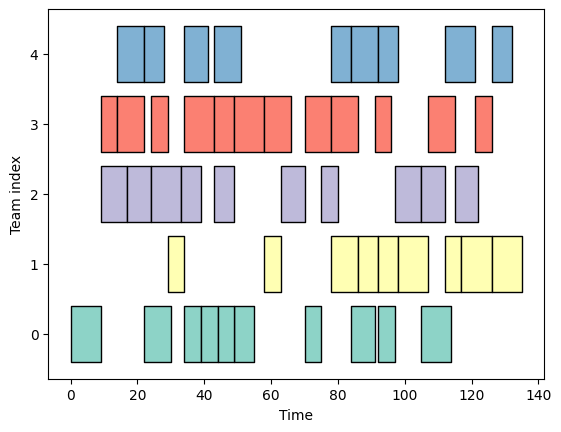

In [6]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap("Set3")

def plot_ghantt(df):
    fig, ax = plt.subplots()
    
    for team in range(n_teams):
        team_tasks = df[df['Team'] == team]
        ax.broken_barh(list(zip(team_tasks["Start"], team_tasks["Duration"])),
                       (team-0.4, 0.8), 
                       facecolors=cmap(team),
                       edgecolor="black")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Team index")
    ax.set_yticks(list(range(n_teams)))
    # ax.set_xlim(0, max(df['Start'] + df['Duration']))
plot_ghantt(solution)